In [1]:
import sys,os
import pickle
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import pickle
import matplotlib.pyplot as plt

In [2]:
adata = sc.read_h5ad(open("/nfs/team283/aa16/KR_NAS/data/CR_cells_AnnData_1.h5ad", "rb"))

In [3]:
DE_results = pd.read_pickle(open("/nfs/team283/aa16/KR_NAS/0_publication_tables/CR_cells_pairwiseDE_cc.p", "rb" ))

In [4]:
DE_results = DE_results['Foetal brain (frontal lobe)_vs_Foetal brain (occipital lobe)']

In [5]:
from adjustText import adjust_text

def plot_volcano_with_reference(log2fc, fdr, pval, genes, total, group1_reference, group2_reference,
                                genesOfInterest = None, n_max_genes = 1, alpha = 0.25, FDR_cutoff = 0.05,
                                height = 10, width = 10, posterios_samples = 1000, saveFig = None):
    r""" Make a volcano plot of the differential expression analysis.
    :genesOfInterest: numpy array of genes to annotate in the plot
    :n_max_genes: number of genes to automatically annotate at the extreme ends of the plot,
    i.e. the most differentially expressed genes
    :alpha: transparency of dots 
    :FDR_cutoff: what false discovery rate to use
    :height: height of figure
    :width: width of figure
    """
    
    fdr = fdr[np.abs(log2fc) < 1000]
    pval = pval[np.abs(log2fc) < 1000]
    genes = genes[np.abs(log2fc) < 1000]
    log2fc = log2fc[np.abs(log2fc) < 1000]
    
    subset2 = [g in group1_reference for g in genes]
    subset3 = [g in group2_reference for g in genes]
    
    # Set figure parameters:
    SMALL_SIZE = 20
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 20
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title    
    
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 1
    plt.rcParams['grid.color'] = "#cccccc"
    
    fig = plt.figure(figsize=(width, height))
    ax1 = plt.subplot2grid((2,3), (0, 0), rowspan=2, colspan = 2)
    ax2 = plt.subplot2grid((2,3), (0, 2))
    ax3 = plt.subplot2grid((2,3), (1, 2))
    
    colours = np.repeat('grey', len(log2fc))
    colours[[log2fc[i] > 1 and fdr[i] < FDR_cutoff for i in range(len(log2fc))]] = 'red'
    colours[[log2fc[i] < -1 and fdr[i] < FDR_cutoff for i in range(len(log2fc))]] = 'blue'
    ax1.scatter(log2fc, -np.log10(pval), c=colours, alpha = alpha)
    ax1.set_xlabel('Log2FC')
    ax1.set_ylabel('-log10(p-value)')
    ax1.set_title('CR cell Occipital vs. Frontal ROIs \n (' + 
                  str(total) +
                 ' genes with FDR < 0.1 and log2FC > 1)')
    plt.grid(True)
    
    if n_max_genes > 0:

        maxGenes = np.array((genes[np.argmax(log2fc)],
                             genes[np.argmin(log2fc)]))
        if genesOfInterest is None:
            genesOfInterest = maxGenes
        else:
            genesOfInterest = np.concatenate((genesOfInterest, maxGenes)) 

    if genesOfInterest is not None:

        geneIndex_to_annotate = np.squeeze([np.where(genes == genesOfInterest[i])
                                            for i in range(len(genesOfInterest))])
        
        ts = []    
        for i,j in enumerate(geneIndex_to_annotate):
            ts.append(ax1.text(log2fc[j], -np.log10(pval)[j], genesOfInterest[i]))
        adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'), ax = ax1, force_points = (5,5))
    
    colours = np.repeat('green', len(log2fc))
    ax2.scatter(log2fc[subset2], -np.log10(pval[subset2]),
                c=colours[subset2], alpha = alpha)
    ax2.set_xlabel('Log2FC')
    ax2.set_ylabel('-log10(p-value)')
    ax2.set_title('Occipital Whole Cortex Markers \n (Literature Derived)')
    plt.grid(True)
    
    colours = np.repeat('green', len(log2fc))
    ax3.scatter(log2fc[subset3], -np.log10(pval[subset3]),
                c=colours[subset3], alpha = alpha)
    ax3.set_xlabel('Log2FC')
    ax3.set_ylabel('-log10(p-value)')
    ax3.set_title('Frontal Whole Cortex Markers \n (Literature Derived)' )
    plt.grid(True)
    
    plt.tight_layout()
    if saveFig:
        plt.savefig(saveFig, bbox_inches="tight")
    plt.show()   

In [6]:
frontal_markers = ['CLMP', 'CTNNBL1', 'CBLN2', 'VSTM2L',
                   'CPNE8', 'SLN', 'CNTN4', 'MB21D2']
occipital_markers = ['PENK', 'EPHA3', 'WSCD1', 'NPY', 'TENM4', 'NR2F1',
                     'FGFR3', 'LHX2', 'WNT7B']
genesOfInterest = np.array(('MMRN2', 'REEP4', 'STH', 'SLCO5A1'))

In [7]:
np.sum([np.abs(DE_results['log2fc'].iloc[i]) > 1 and DE_results['qval'].iloc[i] < 0.1 for i in range(len(DE_results['log2fc']))])

41

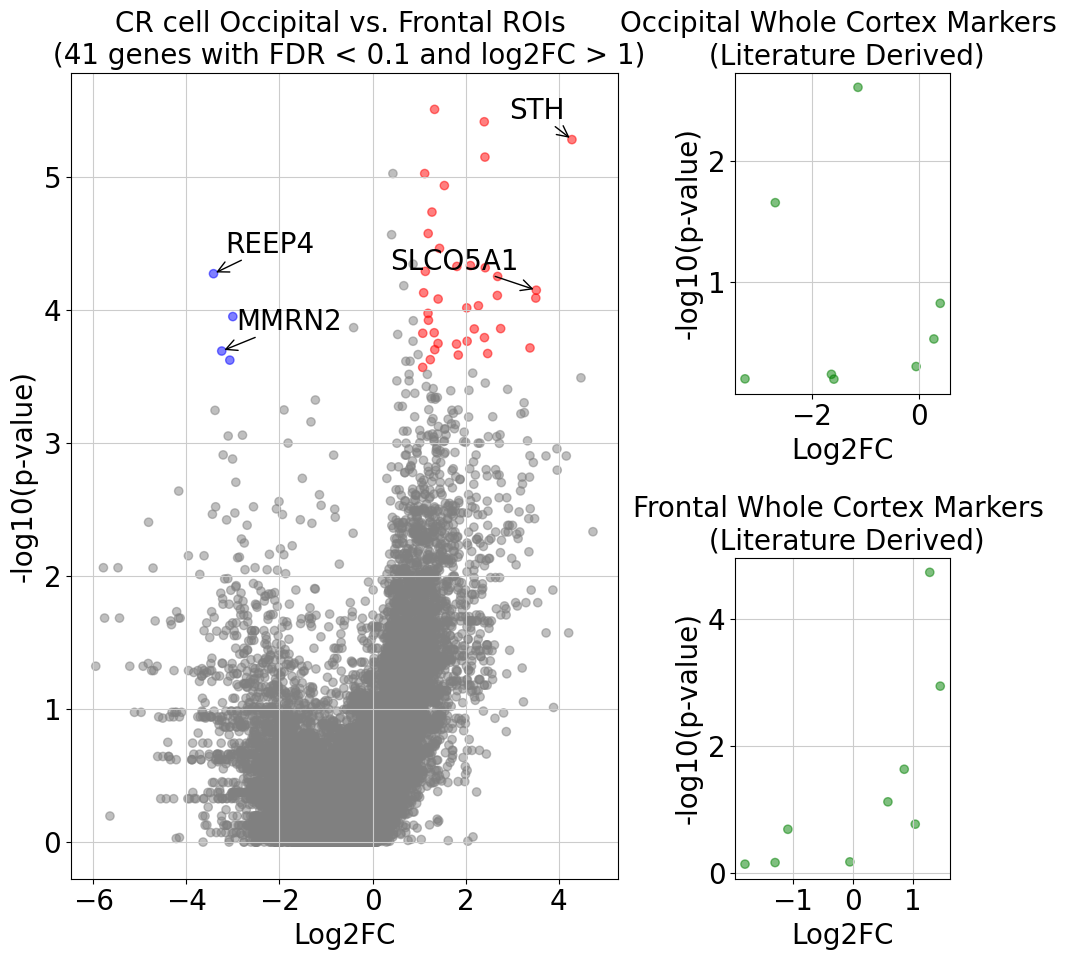

In [8]:
plot_volcano_with_reference(np.array(DE_results['log2fc']),
                            np.array(DE_results['qval']),
                            np.array(DE_results['pval']),
                            np.array(DE_results['gene']),
                            41,
                            frontal_markers, occipital_markers,
                            width = 10, height = 10,
                            n_max_genes = 0,
                            alpha = 0.5,
                            FDR_cutoff = 0.1,
                            genesOfInterest = genesOfInterest,
                            saveFig = '/nfs/team283/aa16/KR_NAS/0_publication_figures/Figure5C_DE-Analysis.pdf')

In [13]:
from adjustText import adjust_text

def plot_volcano(log2fc, fdr, pval, genes, total,
                                genesOfInterest = None, n_max_genes = 1, alpha = 0.25, FDR_cutoff = 0.05,
                                height = 10, width = 10, posterios_samples = 1000, saveFig = None):
    r""" Make a volcano plot of the differential expression analysis.
    :genesOfInterest: numpy array of genes to annotate in the plot
    :n_max_genes: number of genes to automatically annotate at the extreme ends of the plot,
    i.e. the most differentially expressed genes
    :alpha: transparency of dots 
    :FDR_cutoff: what false discovery rate to use
    :height: height of figure
    :width: width of figure
    """
    
    fdr = fdr[np.abs(log2fc) < 1000]
    pval = pval[np.abs(log2fc) < 1000]
    genes = genes[np.abs(log2fc) < 1000]
    log2fc = log2fc[np.abs(log2fc) < 1000]
    
    # Set figure parameters:
    SMALL_SIZE = 20
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 20
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title    
    
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 1
    plt.rcParams['grid.color'] = "#cccccc"
    
    fig, ax1 = plt.subplots(1,1,figsize=(width, height))
    
    colours = np.repeat('grey', len(log2fc))
    colours[[log2fc[i] > 1 and fdr[i] < FDR_cutoff for i in range(len(log2fc))]] = 'red'
    colours[[log2fc[i] < -1 and fdr[i] < FDR_cutoff for i in range(len(log2fc))]] = 'blue'
    ax1.scatter(log2fc, -np.log10(pval), c=colours, alpha = alpha)
    ax1.set_xlabel('Log2FC')
    ax1.set_ylabel('-log10(p-value)')
    ax1.set_title('CR cell Occipital vs. Frontal ROIs \n (' + 
                  str(total) +
                 ' genes with FDR < 0.1 and log2FC > 1)')
    plt.grid(True)
    
    if n_max_genes > 0:

        maxGenes = np.array((genes[np.argmax(log2fc)],
                             genes[np.argmin(log2fc)]))
        if genesOfInterest is None:
            genesOfInterest = maxGenes
        else:
            genesOfInterest = np.concatenate((genesOfInterest, maxGenes)) 

    if genesOfInterest is not None:

        geneIndex_to_annotate = np.squeeze([np.where(genes == genesOfInterest[i])
                                            for i in range(len(genesOfInterest))])
        
        ts = []    
        for i,j in enumerate(geneIndex_to_annotate):
            ts.append(ax1.text(log2fc[j], -np.log10(pval)[j], genesOfInterest[i]))
        adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'), ax = ax1, force_points = (5,5))
    
    plt.tight_layout()
    if saveFig:
        plt.savefig(saveFig, bbox_inches="tight")
    plt.show()   

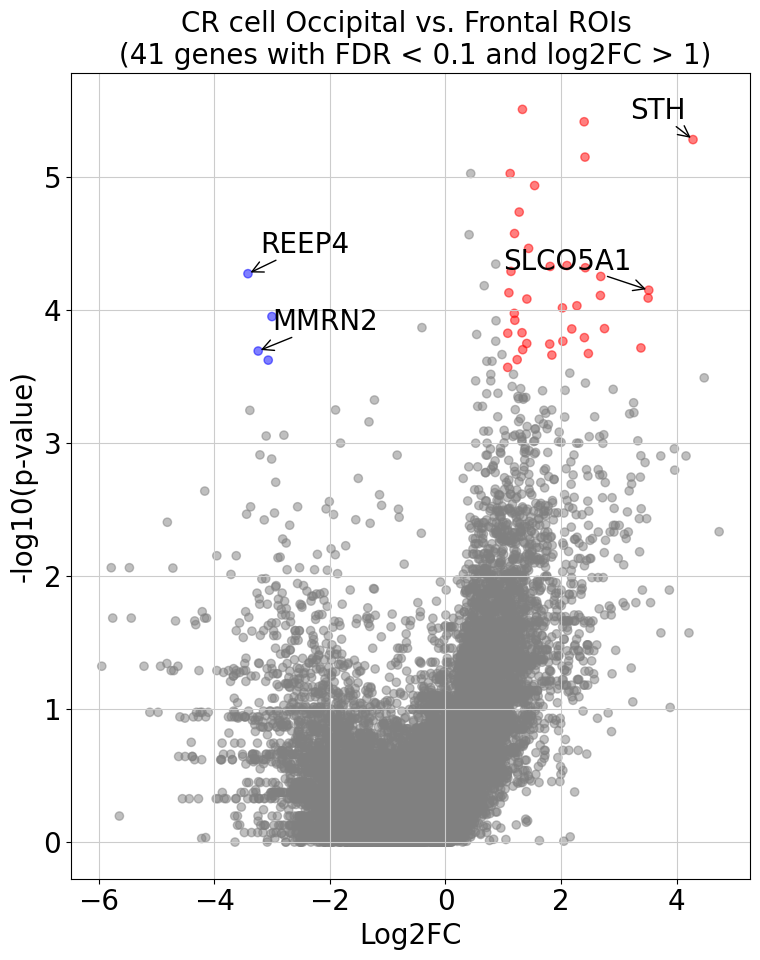

In [15]:
plot_volcano(np.array(DE_results['log2fc']),
                            np.array(DE_results['qval']),
                            np.array(DE_results['pval']),
                            np.array(DE_results['gene']),
                            41,
                            width = 8, height = 10,
                            n_max_genes = 0,
                            alpha = 0.5,
                            FDR_cutoff = 0.1,
                            genesOfInterest = genesOfInterest,
                            saveFig = '/nfs/team283/aa16/KR_NAS/0_publication_figures/Figure5C_DE-Analysis-Simple.pdf')